Importing the libraries

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import glob
import cv2

import random
from random import shuffle

import tensorflow as tf

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras import backend as K
from keras.utils import plot_model


Using TensorFlow backend.


Now Downloading the images and mask folders and unzipping 

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz

!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian

Now Creating the image Generator function 

In [0]:
def img_generator(files, batch_size = 32, size = (256, 256)):
  
  while True: 
    
    #Taking a  random batches of images from complete set of images
    #We should choose replace=False so that each image is chosen only once during the training
    batch = np.random.choice(files, size = batch_size,replace=False)    
    
    #Creating two list .One for storing actual images array
    #and other for image's masks
    #List named input is list for images 
    #And List named output is list for masks
    input_list = []
    output_list = []
    
    
    for f in batch:

        #Opening the image and their corresponding mask 
        img = Image.open(f'images/{f}')
        img_mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        
        #Resizing the image and thier masks 
        img = img.resize(size)
        img_mask=img_mask.resize(size)

        #Now storing as an array
        img = np.array(img)
        img_mask = np.array(img_mask)


        #Converting  the masks array into binary format.
        #All pixel elements will be either 0 or 1
        img_mask[img_mask >= 2] = 0 
        img_mask[img_mask != 0 ] = 1
        
        #Now adding these masks to the list of masks
        output_list.append(img_mask)


        #We need to check the number of channels because
        #some of the images may be RGBA or GRAY
        #if we find any image to be gray scale then we will 
        #convert into RGB stacking the same layer thrice 
        #If some image is RGBA that is Red green blue and alpha 
        #then we will only take first three dimentions from the image 
        #matrix
        if len(img.shape) == 2:
          img = np.stack((img,)*3, axis=-1)

        else:
          img = img[:,:,0:3]


        #Now adding these images to the list of images
        input_list.append(img)

    #Now normalizing the images and converting the list of images 
    #into a array or a 4 dimentional matrix
    input_list = np.array(input_list)/255
    output_list = np.array(output_list)
    output_list = np.expand_dims(output_list,3)

    yield (input_list, output_list)      
    

In [0]:
#Let's define the batch size
batch_size = 32

#Let's get the list of image files from the directory 
img_files = os.listdir('images')

#Lets shuffle the files in order to avoid over or under fitting
shuffle(img_files)

#Let's split the data into test and training data set 
split = int(0.95 * len(img_files))
train_imgs = img_files[0:split]
test_imgs  = img_files[split:]

#Let's get the input and output array.Input array of batches of images 
#And output array for masks for each images
train_gen = img_generator(train_imgs, batch_size = batch_size)
test_gen  = img_generator(test_imgs, batch_size = batch_size)

In [0]:
#Now let's take a batch of size 32 using the previously created generator
X, Y= next(train_gen)

In [27]:
#Lets check the shape of X
#Its showing 32 by 256 by 256 by 3.
#32 for batch size
#256 by 256 for image size
#and 3 for number of channels in the image
#so that makes it a 4 dimentional matrix 
#So elements in the first dimention is basically corresponding to 
# one image
X.shape

(32, 256, 256, 3)

In [28]:
#Lets check the output that is Y.
#Its shape is also 4 dimentional
Y.shape

(32, 256, 256, 1)

In [34]:
#Lets check whats the shape of one element of mask Y 
#and its squeezed shape 
print(Y[0].shape)
print(Y[0].squeeze().shape)

(256, 256, 1)
(256, 256)


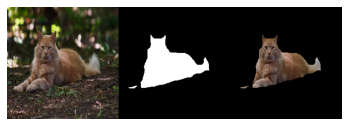

In [36]:
plt.axis('off')

#Now lets take one image from the batch X
img = X[0]

#So now the image is 3 dimentional as it is RGB image

#Now lets take mask of the image aand squeeze it to make it two dimentional
#and then stack this two dimentional image to create three channels having the same pixel values 
#along all the channels
#Basically squeezing and then stacking is done to make it 3 dimentional
#because we will concatenating this mask with image and then convolve it to get segmented image
mask = Y[0].squeeze()
mask = np.stack((mask,)*3, axis=-1)

#Now lets concatenate the image ,its mask and an convolved image 
#Convolution happens with mask on the image 
#So basically third image is the segmented object from the background
plt.imshow( np.concatenate([img, mask, img*mask], axis = 1))

# Now lets define Intersection over Union metric.

 Intersection over Union is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.]

In [0]:
def iou(actual, predictions):
    act = actual[:,:,:,0]
    prd = K.cast(predictions[:,:,:,0] > 0.5, 'float32')

    inter_pixels = tf.count_nonzero(tf.logical_and(tf.equal(act, 1), tf.equal(prd, 1)))
    union_pixels = tf.count_nonzero(tf.add(act, prd))

    iou_metric = tf.where(tf.equal(union_pixels, 0), 1., tf.cast(inter_pixels/union_pixels, 'float32'))
    
    return iou_metric

#Now lets define the Model architecture using the inbuilt Keras methods for convolution and pooling and others.


In [0]:
def unet_model(size = (256, 256, 3)):
  x = Input(size)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  #This piece of code is for contractive path
  #So basically we are doing 2 times convolution taking 8 feature maps with map size of 3 by 3
  #After Convolution there is relu activation 
  #And same padding is used.
  #After two times convolution maxpooling is done 
  #This process repeats six times but important point to note is that each next time this loop repeats 
  #with the filter map size as doubled as previous.
  #We are each time appending x to the list of layers in UNET architechture
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck layer
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #Then we have expansive path
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #Lets define the model now .Feed the inputs and outputs for model training 
  #Model training is done with RMSPROP as optimization algorithm and loss as binary cross entropy
  #and metric as  iou that is intersection over union metric
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [iou])
  
  return model

In [9]:
model = unet_model()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Lets modify the Callbacks class

Lets save the model at each epoch and show predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

#Now lets begin the model Training









i= 1 loss= 0.5442088996166508 val_loss= 0.44700335372578015 mean_iou= 0.20868306825655905 val_mean_iou= 0.412933119318702


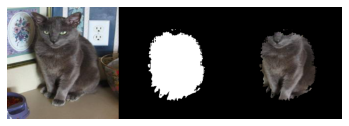

i= 2 loss= 0.43610302607218426 val_loss= 0.4518580138683319 mean_iou= 0.44609294191309035 val_mean_iou= 0.3846635710109364


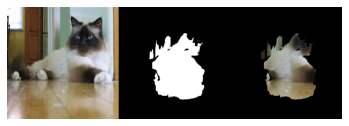

i= 3 loss= 0.40639033342060976 val_loss= 0.3874462057243694 mean_iou= 0.4914436120897123 val_mean_iou= 0.4945072423328053


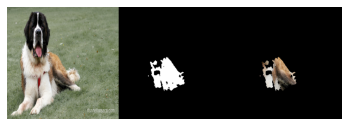

i= 4 loss= 0.3717942808724974 val_loss= 0.36039475961164996 mean_iou= 0.5496278833172638 val_mean_iou= 0.49657785621556366


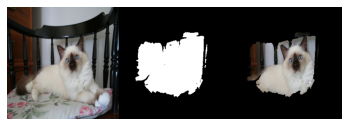

i= 5 loss= 0.3276430868530927 val_loss= 0.31264073198491876 mean_iou= 0.6102507163400519 val_mean_iou= 0.6285954551263289


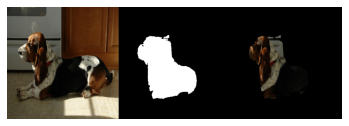

i= 6 loss= 0.2973114175203184 val_loss= 0.27352778207172046 mean_iou= 0.6451944850351168 val_mean_iou= 0.6323833248832009


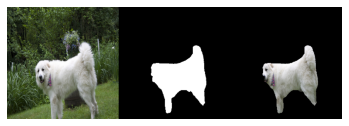

i= 7 loss= 0.2760061480138944 val_loss= 0.23541868410327219 mean_iou= 0.673056133805889 val_mean_iou= 0.7126225720752369


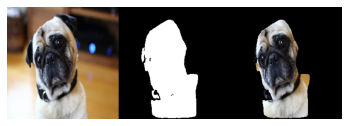

i= 8 loss= 0.2525449949720679 val_loss= 0.25408863208510657 mean_iou= 0.6949005914877538 val_mean_iou= 0.6945883252403953


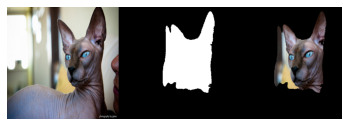

i= 9 loss= 0.23715346568523477 val_loss= 0.23933561146259308 mean_iou= 0.7175812076215875 val_mean_iou= 0.7153905684297736


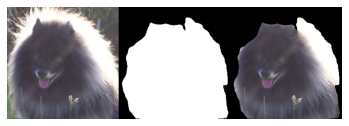

i= 10 loss= 0.2213470013174292 val_loss= 0.32434783469546924 mean_iou= 0.7351835220371752 val_mean_iou= 0.652466974475167


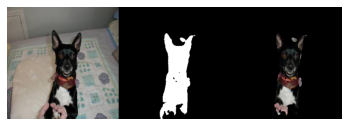

i= 11 loss= 0.20549498001734415 val_loss= 0.21754013814709403 mean_iou= 0.7540033669232233 val_mean_iou= 0.7566912824457342


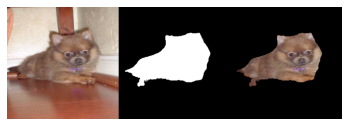

i= 12 loss= 0.19376330928171062 val_loss= 0.23946522989056326 mean_iou= 0.7650516917716422 val_mean_iou= 0.7201772711493752


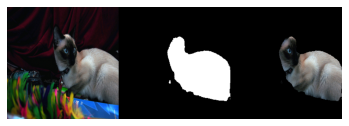

i= 13 loss= 0.18402384929188856 val_loss= 0.20685147019949826 mean_iou= 0.7776752879086151 val_mean_iou= 0.7455040866678412


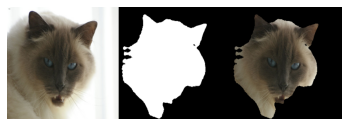

i= 14 loss= 0.173112360479897 val_loss= 0.22107693417505783 mean_iou= 0.7907876715268174 val_mean_iou= 0.7283016768368807


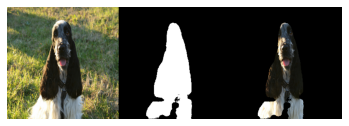

i= 15 loss= 0.1647244410835989 val_loss= 0.17821012843738904 mean_iou= 0.8007984286573924 val_mean_iou= 0.7958300330422141


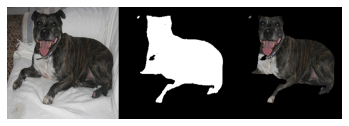

i= 16 loss= 0.1547733411260936 val_loss= 0.22666585580869156 mean_iou= 0.8092645621735212 val_mean_iou= 0.7726408730853688


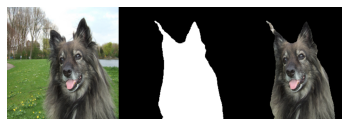

i= 17 loss= 0.14780317434028947 val_loss= 0.18690369616855274 mean_iou= 0.8191278555077505 val_mean_iou= 0.7814282937483354


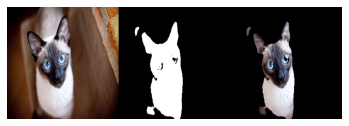

i= 18 loss= 0.1419505466064906 val_loss= 0.22458311509002338 mean_iou= 0.8240941839131046 val_mean_iou= 0.7405816641720858


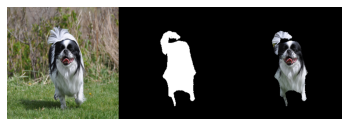

i= 19 loss= 0.13982715787680727 val_loss= 0.19921660287813706 mean_iou= 0.829080457012403 val_mean_iou= 0.7639008543708108


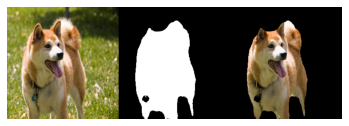

i= 20 loss= 0.13102845725131362 val_loss= 0.19947022064165634 mean_iou= 0.8354031549741144 val_mean_iou= 0.7865463332696394


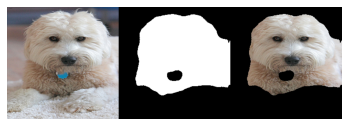

i= 21 loss= 0.12584432231508977 val_loss= 0.21795088865540244 mean_iou= 0.8424194942326306 val_mean_iou= 0.7651578296314586


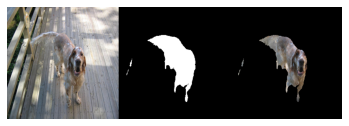

i= 22 loss= 0.12249584424577348 val_loss= 0.21338968385349621 mean_iou= 0.8484586504496396 val_mean_iou= 0.7699678540229797


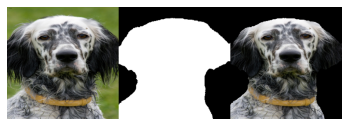

i= 23 loss= 0.11538865063424524 val_loss= 0.20615312457084656 mean_iou= 0.8544033354820182 val_mean_iou= 0.7788834463466298


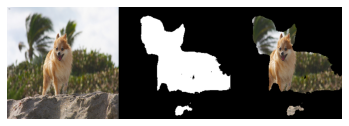

i= 24 loss= 0.11243615632868248 val_loss= 0.20458090169863266 mean_iou= 0.8577998530919149 val_mean_iou= 0.7641887231306597


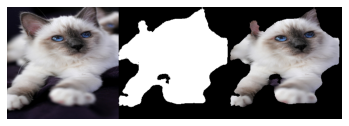

i= 25 loss= 0.10910927786674673 val_loss= 0.22934101792899045 mean_iou= 0.8616716837229794 val_mean_iou= 0.7909093715927817


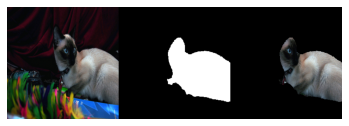

i= 26 loss= 0.10184234050719161 val_loss= 0.3536303002725948 mean_iou= 0.8692319496581543 val_mean_iou= 0.7200127840042114


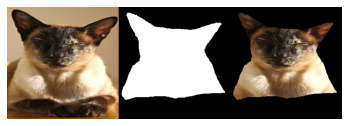

i= 27 loss= 0.1015984007757004 val_loss= 0.2209823659875176 mean_iou= 0.8696066595647978 val_mean_iou= 0.7824335585940968


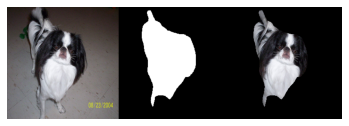

i= 28 loss= 0.09951431222566187 val_loss= 0.20600996776060623 mean_iou= 0.8711068872447427 val_mean_iou= 0.7891412865031849


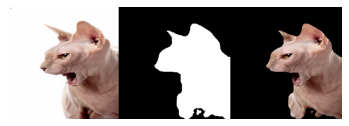

i= 29 loss= 0.09467171255039843 val_loss= 0.227418066425757 mean_iou= 0.8779771352467471 val_mean_iou= 0.7664328109134327


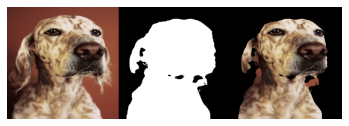

i= 30 loss= 0.09208684200293397 val_loss= 0.2762335037643259 mean_iou= 0.8799640832970675 val_mean_iou= 0.742240006273443


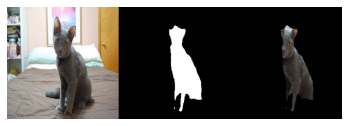

In [11]:
#Lets define the training steps and testing steps
#these are basically the steps after which validation score will be displayed
train_steps = len(train_imgs) //batch_size
test_steps = len(test_imgs) //batch_size

model.fit_generator(train_gen, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_gen, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

Now lets collect the image for testing purpose

In [12]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-21 09:30:32--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.227.198.25, 13.227.198.108, 13.227.198.6, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.227.198.25|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K   356KB/s    in 0.2s    

2020-03-21 09:30:32 (356 KB/s) - ‘test.jpg’ saved [63219/63219]



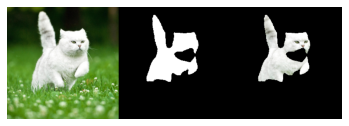

In [13]:
#Now lets read the image and resize and normalize it
img = Image.open('test.jpg')
img = np.array(img.resize((256, 256)))/255
img = img[:,:,0:3]

#Lets now predict the mask 
pred = model.predict(np.expand_dims(img, 0))

#Lets squeeze the mask as before
img_mask  = pred.squeeze()
img_mask = np.stack((img_mask,)*3, axis=-1)
img_mask[img_mask >= 0.5] = 1 
img_mask[img_mask < 0.5] = 0 

#Now lets show the image and its mask and the segmented image 
img_and_mask = np.concatenate([img, img_mask, img* img_mask], axis = 1)
plt.axis('off')
plt.imshow(img_and_mask)
plt.show()